基于决策树算法的英雄联盟游戏胜负预测

任务介绍

英雄联盟（League of Legends，LoL）是一款多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。游戏中，每位玩家控制一位拥有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初较弱，需要击杀小兵、野怪和对方英雄来获得金币和经验。经验可以提升英雄等级和技能等级，金币可用来购买装备提升攻击、防御等属性。对战中没有己方单位附近的地点会没有视野，即无法看到对面单位。双方可以通过使用守卫来监视某个地点，洞察对面走向并制定战术。

本数据集来自Kaggle，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

作业说明
基本任务（80）：
1.合理的进行特征工程处理
2. 划分训练集和测试集
3. 使用决策树算法完成游戏胜负的预测
4. 对比不同特征组合对模型效果的影响；
5. 提交代码和实验报告。
扩展任务（20）：
1.尝试自行实现决策树算法细节；
2.决策树算法的调参

In [1]:
import pandas as pd  # 数据处理
import numpy as np  # 数学运算
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_validate  # 划分数据集函数
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # 准确率函数
import matplotlib.pyplot as plt  # 作图
import seaborn as sns  # 作图
from sklearn.decomposition import PCA

In [2]:
csv_data = 'high_diamond_ranked_10min.csv'  # 数据路径
data_df = pd.read_csv(csv_data, sep=',')  # 读入csv文件为pandas的DataFrame
data_df = data_df.drop(columns='gameId')  # 舍去对局标号列

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   float64
 13  blu

In [4]:
#获取所有特征
features1 = data_df.columns[1:]
data_df1 = data_df.copy()
features1

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons',
       'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

In [5]:
# 只保留差值的增删特征
drop_features = ['blueGoldDiff', 'redGoldDiff',
                 'blueExperienceDiff', 'redExperienceDiff',
                 'blueCSPerMin', 'redCSPerMin',
                 'blueGoldPerMin', 'redGoldPerMin',
                 'blueFirstBlood', 'redFirstBlood']
# 需要舍去的无用特征列
df = data_df.drop(columns=drop_features)  # 舍去特征列
info_names = [c[3:]
              for c in df.columns if c.startswith('red')]  # 取出要作差值的特征名字（除去red前缀）
for info in info_names:  # 对于每个特征名字
    df['br' + info] = df['blue' + info] - df['red' + info]  # 构造一个新的特征，由蓝色特征减去红色特征，前缀为br
    df = df.drop(columns=['blue' + info, 'red' + info])  # 保留差值
df[df['blueWins'] >= 1].describe()
df.describe()

blueWins  brWardsPlaced  brWardsDestroyed      brKills     brDeaths  \
count  9879.000000    9879.000000       9879.000000  9879.000000  9879.000000   
mean      0.499038      -0.079664          0.101731     0.046260    -0.046260   
std       0.500024      25.960582          2.854910     4.195489     4.195489   
min       0.000000    -260.000000        -23.000000   -17.000000   -16.000000   
25%       0.000000      -4.000000         -1.000000    -3.000000    -3.000000   
50%       0.000000       0.000000          0.000000     0.000000     0.000000   
75%       1.000000       4.000000          1.000000     3.000000     3.000000   
max       1.000000     234.000000         23.000000    16.000000    17.000000   

         brAssists  brEliteMonsters    brDragons    brHeralds  \
count  9879.000000      9879.000000  9879.000000  9879.000000   
mean     -0.017006        -0.023180    -0.051119     0.027938   
std       5.766787         1.067934     0.878945     0.589292   
min     -25.000000        -2.000000    -1.000000    -1.000000   
25%      -4.000000        -1.000000    -1.000000     0.000000   
50%       0.000000         0.000000     0.000000     0.000000   
75%       4.000000         1.000000     1.000000     0.000000   
max      23.000000         2.000000     1.000000     1.000000   

       brTowersDestroyed   brTotalGold   brAvgLevel  brTotalExperience  \
count        9879.000000   9879.000000  9879.000000        9879.000000   
mean            0.008402     14.414111    -0.009313         -33.620306   
std             0.324835   2453.349179     0.478434        1920.370438   
min            -2.000000 -10830.000000    -2.600000       -9333.000000   
25%             0.000000  -1585.500000    -0.400000       -1290.500000   
50%             0.000000     14.000000     0.000000         -28.000000   
75%             0.000000   1596.000000     0.200000        1212.000000   
max             4.000000  11467.000000     2.400000        8348.000000   

       brTotalMinionsKilled  brTotalJungleMinionsKilled  
count           9879.000000                 9879.000000  
mean              -0.649661                   -0.803421  
std               30.942675                   14.274733  
min             -120.000000                  -72.000000  
25%              -21.000000                  -10.000000  
50%               -1.000000                    0.000000  
75%               20.000000                    8.000000  
max              127.000000                   64.000000

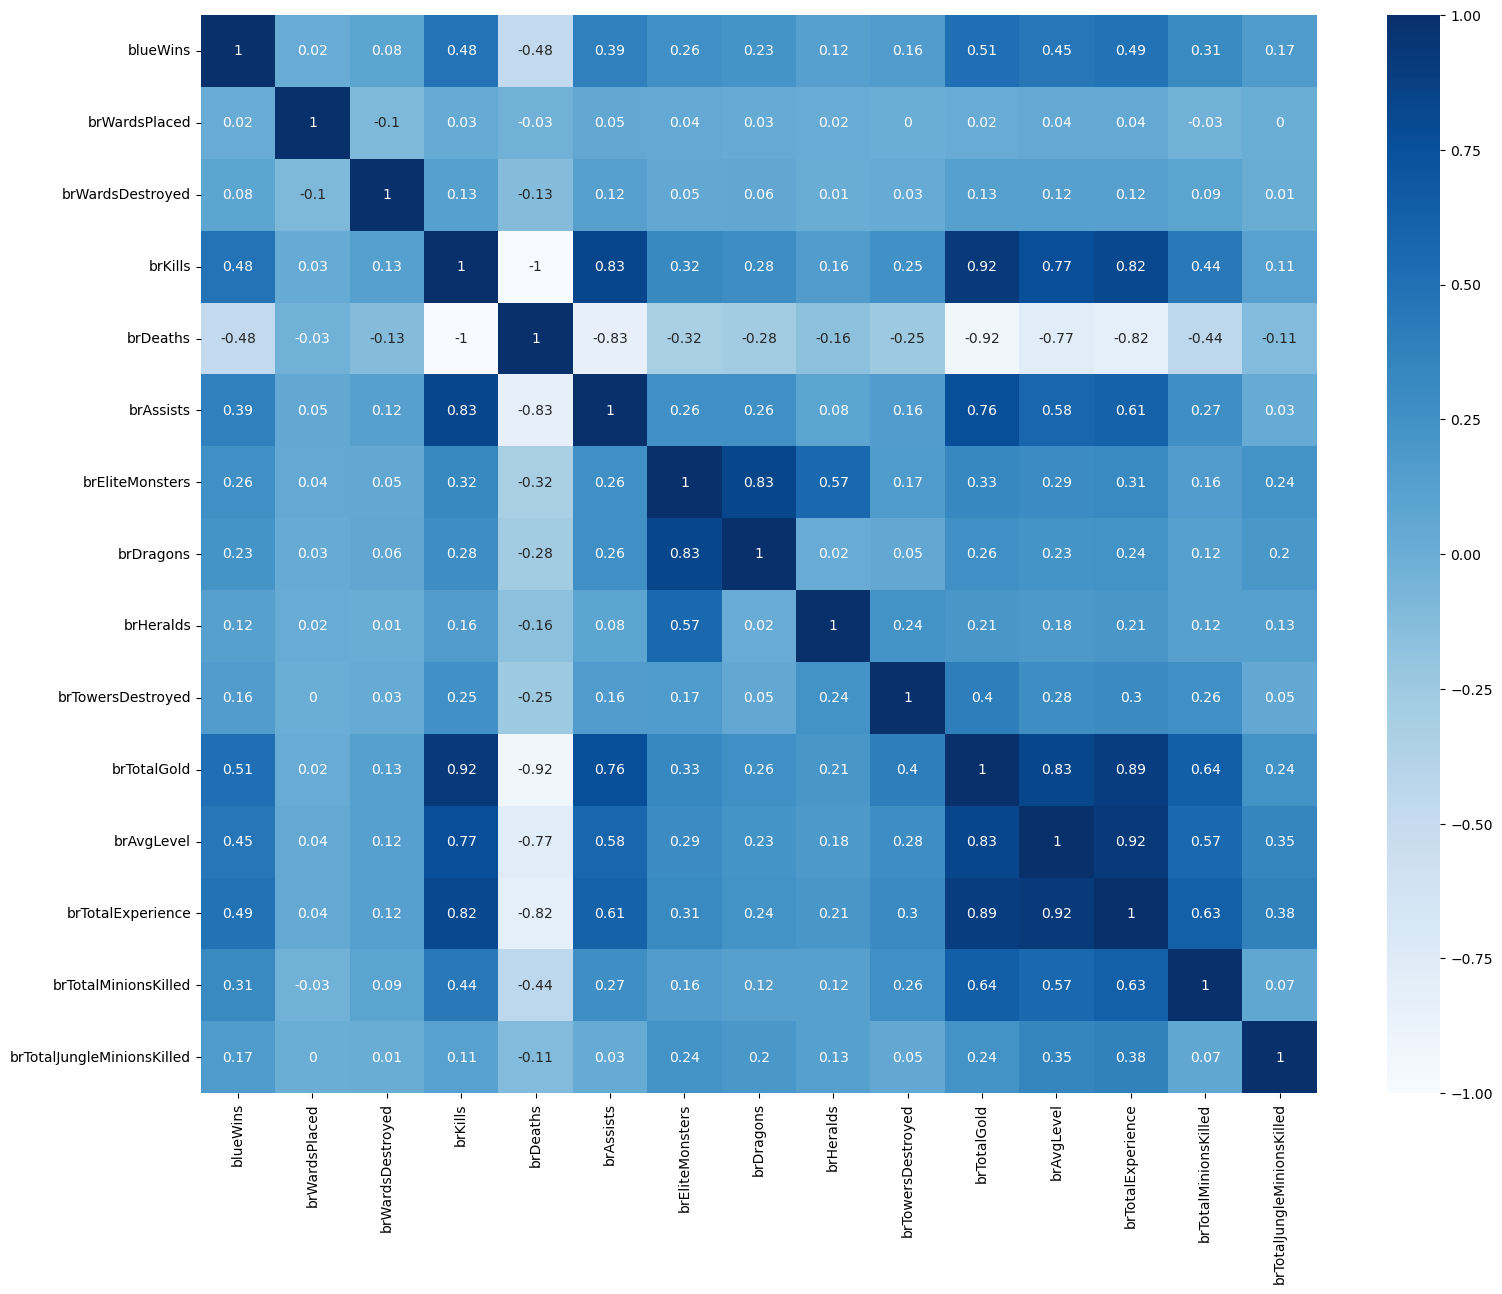

In [6]:
plt.figure(figsize=(18, 14))
sns.heatmap(round(df.corr(), 2), cmap='Blues', annot=True)
plt.show()

In [7]:
df = df.drop(columns=['brWardsDestroyed',
                      'brWardsPlaced',
                      'brTowersDestroyed',
                      'brTotalMinionsKilled',
                      'brHeralds'])
df.describe()

blueWins      brKills     brDeaths    brAssists  brEliteMonsters  \
count  9879.000000  9879.000000  9879.000000  9879.000000      9879.000000   
mean      0.499038     0.046260    -0.046260    -0.017006        -0.023180   
std       0.500024     4.195489     4.195489     5.766787         1.067934   
min       0.000000   -17.000000   -16.000000   -25.000000        -2.000000   
25%       0.000000    -3.000000    -3.000000    -4.000000        -1.000000   
50%       0.000000     0.000000     0.000000     0.000000         0.000000   
75%       1.000000     3.000000     3.000000     4.000000         1.000000   
max       1.000000    16.000000    17.000000    23.000000         2.000000   

         brDragons   brTotalGold   brAvgLevel  brTotalExperience  \
count  9879.000000   9879.000000  9879.000000        9879.000000   
mean     -0.051119     14.414111    -0.009313         -33.620306   
std       0.878945   2453.349179     0.478434        1920.370438   
min      -1.000000 -10830.000000    -2.600000       -9333.000000   
25%      -1.000000  -1585.500000    -0.400000       -1290.500000   
50%       0.000000     14.000000     0.000000         -28.000000   
75%       1.000000   1596.000000     0.200000        1212.000000   
max       1.000000  11467.000000     2.400000        8348.000000   

       brTotalJungleMinionsKilled  
count                 9879.000000  
mean                    -0.803421  
std                     14.274733  
min                    -72.000000  
25%                    -10.000000  
50%                      0.000000  
75%                      8.000000  
max                     64.000000

In [8]:
discrete_df = df.copy()

In [9]:
def discrete_fea(df, discrete_df, dis_thre=10, method='qcut'):
    for c in df.columns[1:]:
        # 些特征本身取值就很少，可以跳过
        if len(set(discrete_df[c])) <= dis_thre:
            continue

        elif method == 'cut':
            discrete_df[c] = pd.cut(df[c], dis_thre, labels=[i for i in range(dis_thre)])
        else:
            discrete_df[c] = pd.qcut(
                df[c], dis_thre, precision=0, labels=False, duplicates='drop')
    return df, discrete_df


df, discrete_df = discrete_fea(df, discrete_df, 3, 'qcut')

In [10]:
all_y = discrete_df['blueWins'].values  # 所有标签数据
feature_names = discrete_df.columns[1:]  # 所有特征的名称
all_x = discrete_df[feature_names].values  # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵
# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=20030722)
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape  # 输出数据行列信息

((9879,), (9879, 9), (7903, 9), (1976, 9), (7903,), (1976,))

In [ ]:
# 定义决策树类
class DecisionTree(object):
    def __init__(self, classes, features,
                 max_depth=10, min_samples_split=10,
                 impurity_t='entropy'):

        self.classes = classes
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_t = impurity_t
        self.root = None  # 定义根节点，未训练时为空
        self.tree = defaultdict(list)

    # 要调用sklearn的cross_validate需要实现该函数返回所有参数
    def get_params(self, deep):
        return {'classes': self.classes, 'features': self.features,
                'max_depth': self.max_depth, 'min_samples_split': self.min_samples_split,
                'impurity_t': self.impurity_t}

    # 要调用sklearn的GridSearchCV需要实现该函数给类设定所有参数
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def impurity(self, label):
        '''
        计算不纯度，根据传入参数计算信息熵或gini系数
        label是numpy一维数组：根据当前特征划分后的标签组成
        '''
        cnt, total = Counter(label), float(len(label))
        probs = [cnt[v] / total for v in cnt]
        if self.impurity_t == 'gini':
            return 1 - sum([p * p for p in probs])
        return -sum([p * np.log2(p) for p in probs if p > 0])

    def gain(self, feature, label) -> tuple:

        # 未分裂前的混杂度，仅仅根据标签计算
        p_impurity = self.impurity(label)

        # 记录特征的每种取值所对应的样本下标
        f_index = defaultdict(list)
        for idx, v in enumerate(feature):
            f_index[v].append(idx)

        # 根据该特征分裂后的不纯度，与特征的每种值的数目加权和
        c_impurity = 0
        for v in f_index:
            f_l = label[f_index[v]]
            c_impurity += self.impurity(f_l) * len(f_l) / len(label)

        # 计算信息增益率，即在标签无关时的不纯度
        # 防止对特征取值多的天然偏执，防止过拟合
        r = self.impurity(feature)
        r = (p_impurity - c_impurity) / (r if r != 0 else 1)
        return r, f_index

    def expand_node(self, feature, label, depth, used_features) -> tuple:

        # 1. 递归终止条件：只有一种类别无需分裂 或 达到分裂阈值，返回叶结点
        if len(set(label)) == 0:
            return label[0]
        most = Counter(label).most_common(1)[0][0]
        if depth > self.max_depth or len(label) < self.min_samples_split:
            return most

        # 2. 遍历所有未使用特征，调用gain()找到最佳分裂特征
        bestf, max_gain, bestf_idx = -1, -1, None
        for f in range(len(self.features)):
            if f in used_features:
                continue
            # 计算该特征的信息增益，和每个取值的样本下标
            f_gain, f_idx = self.gain(feature[:, f], label)
            if bestf < 0 or f_gain > max_gain:
                bestf, max_gain, bestf_idx = f, f_gain, f_idx

        # 3. 如果找不到有用的分裂特征，也结束递归
        if bestf < 0:
            return most

        # 4. 遍历特征的每种取值，递归调用expand_node进行建树，decision{特征取值：子结点}
        children = {}
        new_used_features = used_features + [bestf]
        for v in bestf_idx:
            c_idx = bestf_idx[v]
            children[v] = self.expand_node(feature[c_idx, :],
                                           label[c_idx], depth + 1, new_used_features)
        self.tree[depth].append(self.features[bestf])
        return (bestf, children, most)

    def traverse_node(self, node, feature):
        # 要求输入样本特征数和模型定义时特征数目一致
        assert len(self.features) == len(feature)
        # 已经到达叶节点，则返回分类结果
        if type(node) is not tuple:
            return node
        # 依据特征取值进入相应子节点，递归调用traverse_node，node[0]记录了特征的下标.
        fv = feature[node[0]]
        if fv in node[1]:
            return self.traverse_node(node[1][fv], feature)
        # 该特征取值在训练集中未出现过，返回训练时到达当前节点的样本中最多的类别
        return node[-1]

    def fit(self, feature, label):
        assert len(self.features) == len(
            feature[0])  # 输入数据的特征数目应该和模型定义时的特征数目相同
        # 从根节点开始分裂，模型记录根节点
        self.root = self.expand_node(
            feature, label, depth=1, used_features=[])

    def predict(self, feature):
        assert len(feature.shape) == 1 or len(feature.shape) == 2  # 只能是1维或2维
        if len(feature.shape) == 1:  # 如果是一个样本
            return self.traverse_node(self.root, feature)  # 从根节点开始路由
        # 如果是很多个样本
        return np.array([self.traverse_node(self.root, f) for f in feature])

In [ ]:
# 定义决策树模型，传入算法参数
DT = DecisionTree(classes=[0, 1], features=feature_names,
                  max_depth=3, min_samples_split=450, impurity_t='gini')

DT.fit(x_train, y_train)  # 在训练集上训练
p_test = DT.predict(x_test)  # 在测试集上预测，获得预测值
print('pred_value ', p_test)  # 输出预测值
print('true_value ', y_test)
test_acc = accuracy_score(y_test, p_test)  # 将测试预测值与测试集标签对比获得准确率
precision = precision_score(y_test, p_test)
recall = recall_score(y_test, p_test)
f1 = f1_score(y_test, p_test)
print('\nTREE:')
for _ in DT.tree.keys():
    print('Layer' + str(_) + ':' + str(DT.tree[_]))
print('\naccuracy: {:.4f}   precision: {:.4f}   recall: {:.4f}   f1_score: {:.4f}'.format(
    test_acc, precision, recall, f1))  # 输出准确率

In [13]:
discrete_df1 = data_df1.copy()
data_df1, discrete_df1 = discrete_fea(data_df1, discrete_df1, 3, 'qcut')

In [14]:
# 对比其他特征组合对模型的影响
# 尝试输入全部特征
all_y1 = discrete_df1['blueWins'].values  # 所有标签数据
feature_names1 = features1  # 所有特征的名称
all_x1 = discrete_df1[feature_names1].values  # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵
# 划分训练集和测试集
x_train1, x_test1, y_train1, y_test1 = train_test_split(all_x1, all_y1, test_size=0.2, random_state=20030722)
all_y1.shape, all_x1.shape, x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape  # 输出数据行列信息

((9879,), (9879, 38), (7903, 38), (1976, 38), (7903,), (1976,))

In [15]:
x_train1[:5], y_train1[:5]

(array([[0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 2, 1, 1, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
        [2, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 1, 2, 2, 2, 2],
        [1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1],
        [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
         2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 1, 2],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,
         1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2]]),
 array([0, 0, 1, 0, 0]))

In [16]:
# 定义决策树模型，传入算法参数
DT = DecisionTree(classes=[0, 1], features=features1,
                  max_depth=3, min_samples_split=450, impurity_t='gini')

DT.fit(x_train1, y_train1)  # 在训练集上训练
p_test1 = DT.predict(x_test1)  # 在测试集上预测，获得预测值
print('pred_value ', p_test1)  # 输出预测值
print('true_value ', y_test1)
test_acc = accuracy_score(y_test1, p_test1)  # 将测试预测值与测试集标签对比获得准确率
precision = precision_score(y_test1, p_test1)
recall = recall_score(y_test1, p_test1)
f1 = f1_score(y_test1, p_test1)
print('\nTREE:')
for _ in DT.tree.keys():
    print('Layer' + str(_) + ':' + str(DT.tree[_]))
print('\naccuracy: {:.4f}   precision: {:.4f}   recall: {:.4f}   f1_score: {:.4f}'.format(
    test_acc, precision, recall, f1))  # 输出准确率

pred_value  [0 1 0 ... 0 1 0]
true_value  [0 1 0 ... 0 0 1]

TREE:
Layer3:['redTowersDestroyed', 'blueExperienceDiff', 'blueTotalExperience', 'blueExperienceDiff', 'blueExperienceDiff', 'redTowersDestroyed']
Layer2:['blueDragons', 'blueDragons', 'redExperienceDiff']
Layer1:['blueGoldDiff']

accuracy: 0.7313   precision: 0.7595   recall: 0.6824   f1_score: 0.7189


In [17]:
## 随机选择20个特征 看看效果
import random

random_features = random.sample(list(features1), 20)
random_features

['redAvgLevel',
 'blueEliteMonsters',
 'redGoldDiff',
 'redDeaths',
 'blueFirstBlood',
 'blueTotalMinionsKilled',
 'redHeralds',
 'blueDeaths',
 'blueKills',
 'blueHeralds',
 'blueGoldDiff',
 'blueDragons',
 'blueWardsPlaced',
 'blueCSPerMin',
 'redTotalMinionsKilled',
 'redWardsPlaced',
 'redWardsDestroyed',
 'blueAssists',
 'blueTotalGold',
 'redTotalGold']

In [18]:
data = data_df[random_features]

In [19]:
data1 = data.copy()

In [20]:
data, data1 = discrete_fea(data, data1, 3, 'qcut')

In [21]:
# 对比其他特征组合对模型的影响
# 尝试输入随机20个特征
all_y2 = data_df['blueWins'].values  # 所有标签数据
feature_names2 = random_features  # 所有特征的名称
all_x2 = data1[random_features].values  # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵
# 划分训练集和测试集
x_train2, x_test2, y_train2, y_test2 = train_test_split(all_x2, all_y2, test_size=0.2, random_state=20030722)
all_y2.shape, all_x2.shape, x_train2.shape, x_test2.shape, y_train2.shape, y_test2.shape  # 输出数据行列信息

((9879,), (9879, 20), (7903, 20), (1976, 20), (7903,), (1976,))

In [22]:
x_train2[:5], y_train2[:5]

(array([[6.8, 0. , 1. , 0. , 1. , 2. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
         2. , 1. , 1. , 0. , 1. , 1. , 0. ],
        [7. , 1. , 2. , 1. , 0. , 0. , 1. , 2. , 1. , 0. , 0. , 1. , 2. ,
         0. , 2. , 1. , 1. , 1. , 0. , 2. ],
        [7. , 1. , 2. , 0. , 0. , 2. , 0. , 0. , 0. , 0. , 0. , 1. , 1. ,
         2. , 2. , 2. , 1. , 0. , 0. , 1. ],
        [7.4, 0. , 2. , 0. , 0. , 1. , 1. , 2. , 0. , 0. , 0. , 0. , 0. ,
         1. , 1. , 1. , 1. , 0. , 0. , 2. ],
        [7. , 1. , 2. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 1. , 0. ,
         0. , 1. , 2. , 1. , 1. , 0. , 2. ]]),
 array([0, 0, 1, 0, 0]))

In [23]:
# 定义决策树模型，传入算法参数
DT = DecisionTree(classes=[0, 1], features=random_features,
                  max_depth=3, min_samples_split=450, impurity_t='gini')

DT.fit(x_train2, y_train2)  # 在训练集上训练
p_test2 = DT.predict(x_test2)  # 在测试集上预测，获得预测值
print('pred_value ', p_test2)  # 输出预测值
print('true_value ', y_test2)
test_acc = accuracy_score(y_test2, p_test2)  # 将测试预测值与测试集标签对比获得准确率
precision = precision_score(y_test2, p_test2)
recall = recall_score(y_test2, p_test2)
f1 = f1_score(y_test2, p_test2)
print('\nTREE:')
for _ in DT.tree.keys():
    print('Layer' + str(_) + ':' + str(DT.tree[_]))
print('\naccuracy: {:.4f}   precision: {:.4f}   recall: {:.4f}   f1_score: {:.4f}'.format(
    test_acc, precision, recall, f1))  # 输出准确率

pred_value  [0 1 0 ... 0 1 0]
true_value  [0 1 0 ... 0 0 1]

TREE:
Layer3:['blueTotalGold', 'redTotalGold', 'redAvgLevel', 'blueEliteMonsters', 'blueTotalGold', 'redDeaths']
Layer2:['blueDragons', 'blueDragons', 'redTotalGold']
Layer1:['redGoldDiff']

accuracy: 0.7222   precision: 0.7419   recall: 0.6874   f1_score: 0.7136


## 对模型进行调优

In [24]:
# 使用5折交叉验证调整参数
best = None
min_samples_split = 1
best_depth = 0
for impurity_t in ['entropy', 'gini']:
    accuracys = []
    # 遍历最大树深度
    for max_depth in range(1, 11):
        DT = DecisionTree(classes=[0, 1], features=feature_names,
                          max_depth=max_depth, min_samples_split=min_samples_split, impurity_t=impurity_t)
        cv_result = cross_validate(
            DT, all_x, all_y, scoring=('accuracy'), cv=5)
        test_acc = np.mean(cv_result['test_score'])
        current = (test_acc, max_depth, min_samples_split,
                   impurity_t)
        accuracys.append(current[0])
        if best is None or test_acc > best[0]:
            best = current
            best_depth = max_depth
            print('better accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *best))

        else:
            print('accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *current))
    print(accuracys)

better accuracy: 0.7009, max_depth=1, min_samples_split=1, impurity_t=entropy
better accuracy: 0.7127, max_depth=2, min_samples_split=1, impurity_t=entropy
better accuracy: 0.7306, max_depth=3, min_samples_split=1, impurity_t=entropy
accuracy: 0.7286, max_depth=4, min_samples_split=1, impurity_t=entropy
accuracy: 0.7243, max_depth=5, min_samples_split=1, impurity_t=entropy
accuracy: 0.7157, max_depth=6, min_samples_split=1, impurity_t=entropy
accuracy: 0.7126, max_depth=7, min_samples_split=1, impurity_t=entropy
accuracy: 0.7071, max_depth=8, min_samples_split=1, impurity_t=entropy
accuracy: 0.7024, max_depth=9, min_samples_split=1, impurity_t=entropy
accuracy: 0.7024, max_depth=10, min_samples_split=1, impurity_t=entropy
[0.7008805924255623, 0.7127237226464408, 0.7306399323527903, 0.7286156921027007, 0.7242637216214831, 0.715659509045252, 0.712622559319428, 0.7070552964690207, 0.7023993747757904, 0.7023993747757904]
accuracy: 0.7009, max_depth=1, min_samples_split=1, impurity_t=gini
a

In [25]:
best = None
max_depth = best_depth
for impurity_t in ['entropy', 'gini']:
    accuracys = []
    # 遍历节点分裂最小样本数的阈值
    for min_samples_split in range(50, 800, 50):
        DT = DecisionTree(classes=[0, 1], features=feature_names,
                          max_depth=max_depth, min_samples_split=min_samples_split, impurity_t=impurity_t)
        cv_result = cross_validate(
            DT, all_x, all_y, scoring=('accuracy'), cv=5)
        test_acc = np.mean(cv_result['test_score'])
        current = (test_acc, max_depth, min_samples_split,
                   impurity_t)
        accuracys.append(current[0])
        if best is None or test_acc > best[0]:
            best = current  # 记录最好结果
            print('better accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *best))  # 输出准确率和参数

        else:
            print('accuracy: {:.4f}, max_depth={}, min_samples_split={}, impurity_t={}'.format(
                *current))  # 输出准确率和参数
    print(accuracys)

better accuracy: 0.7306, max_depth=3, min_samples_split=50, impurity_t=entropy
accuracy: 0.7306, max_depth=3, min_samples_split=100, impurity_t=entropy
accuracy: 0.7306, max_depth=3, min_samples_split=150, impurity_t=entropy
accuracy: 0.7305, max_depth=3, min_samples_split=200, impurity_t=entropy
accuracy: 0.7305, max_depth=3, min_samples_split=250, impurity_t=entropy
accuracy: 0.7305, max_depth=3, min_samples_split=300, impurity_t=entropy
accuracy: 0.7305, max_depth=3, min_samples_split=350, impurity_t=entropy
accuracy: 0.7305, max_depth=3, min_samples_split=400, impurity_t=entropy
better accuracy: 0.7307, max_depth=3, min_samples_split=450, impurity_t=entropy
accuracy: 0.7307, max_depth=3, min_samples_split=500, impurity_t=entropy
accuracy: 0.7298, max_depth=3, min_samples_split=550, impurity_t=entropy
accuracy: 0.7298, max_depth=3, min_samples_split=600, impurity_t=entropy
accuracy: 0.7298, max_depth=3, min_samples_split=650, impurity_t=entropy
accuracy: 0.7298, max_depth=3, min_sam

Text(0, 0.5, 'accurancy')

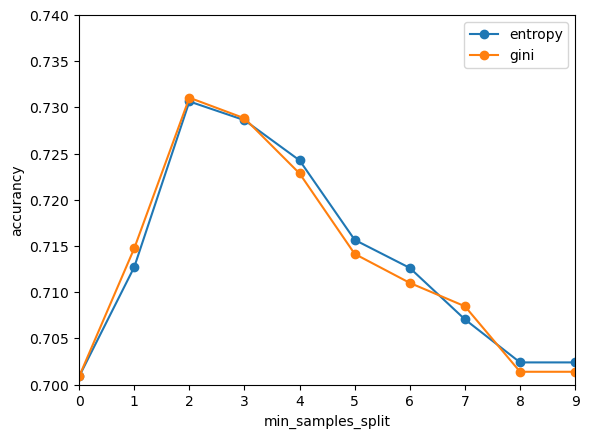

In [26]:
# 准确率随着参数变化，折线图的绘制
from matplotlib import pyplot
import matplotlib.pyplot as plt

y_1 = [0.7008805924255623, 0.7127237226464408, 0.7306399323527903, 0.7286156921027007, 0.7242637216214831,
       0.715659509045252, 0.712622559319428, 0.7070552964690207, 0.7023993747757904, 0.7023993747757904]
x = range(len(y_1))
y_2 = [0.7008805924255623, 0.714749039102137, 0.7310449956439297, 0.7288182749961565, 0.7228465638292421,
       0.7141406241992517, 0.7110029723773894, 0.7084719930302874, 0.7013867165479424, 0.7013867165479424]
#plt.plot(x, y, 'ro-')
#plt.plot(x, y1, 'bo-')
#pl.xlim(-1, 11)  # 限定横轴的范围
plt.ylim(0.70, 0.74)  # 限定纵轴的范围

plt.plot(x, y_1, marker='o', label='entropy')
plt.plot(x, y_2, marker='o', label='gini')
plt.legend()  # 让图例生效

plt.margins(0)
# plt.subplots_adjust(bottom=0.10)
plt.xlabel('min_samples_split')  # X轴标签
plt.ylabel("accurancy")  #Y轴标签
#plt.title("A simple plot") #标题

In [27]:
 # 使用sklearn封装好的决策树，寻找优化上界
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

parameters = {
    'splitter': ('best', 'random'),
    'criterion': ('gini', 'entropy'),
    'max_depth': [*range(1, 20, 2)],
}

clf = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(x_train, y_train)
GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'splitter': ('best', 'random')})
# 输出最佳得分
print("best score: ", GS.best_score_)
print("best param: ", GS.best_params_)

best score:  0.7263081502344413
best param:  {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}


In [28]:
 # 最佳模型
best_clf = DecisionTreeClassifier(
    criterion="gini", max_depth=7, splitter="best")
best_clf.fit(x_train, y_train)
print("score:", best_clf.score(x_test, y_test))
# 输出分类报告
y_pred = best_clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print('Classification report : \n', cr)

score: 0.7241902834008097
Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.73      0.72       981
           1       0.73      0.72      0.72       995

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976

